In [1]:
import pandas as pd
from pandas import DataFrame
from datetime import date
import calendar
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from IPython.display import display, HTML
from bs4 import BeautifulSoup
import requests
from scipy import stats
%matplotlib inline

cd = os.path.split(os.getcwd())[0]
if cd not in sys.path:
    sys.path.append(cd)

from lib import noaa, bexarcrime


# Set this to true if you want to run it from scratch
# IE pulling all the data from source and running all the slow
# functions
PROCESS_FULLY = False

# Table of Contents <a class="anchor" id="toc"></a>
* [City Selection](#selection)
  * [Loading](#loading)
  * [Merging](#merging)
  * [Visualisations](#visualisations)
* [Data Acquisition](#acquisition)
* [Data Analysis](#analysis)
  * [Hypthesis](#hypothesis)
  * [Exploration](#exploration)
* [Results and Conclusions](#results)

## City Selection <a class="anchor" id="selection"></a>

[Back to Table of Contents](#toc)

First we need to find which cities to examine. We loaded datasets full of factors that we thought influenced violent crime at the county level, and then chose the county seats of those counties to examine in detail

### Loading the Datasets <a class="anchor" id="loading"></a>

[Back to Table of Contents](#toc)

First we load the datasets into dataframes, later on we'll merge them into a single one to examine

County-level crime dataset

In [2]:
# using crime reports, not arrests 
crime = pd.read_csv('../data/CountyCrimeReports.tsv', sep='\t')
crime['FIPS'] = crime['FIPS_ST'] * 1000 + crime['FIPS_CTY']
crime['vcrime'] = crime['MURDER'] + crime['RAPE'] + crime['ROBBERY'] + crime['AGASSLT']
crime = crime.set_index('FIPS')
crime = crime[['COVIND', 'vcrime']]

Education dataset

In [3]:
edu = pd.read_excel('../data/Education.xls', skiprows=4)

# state and areas are named nicely in this dataset and will be kept for the later 'join'
# columns[-4:] include most recent data for adults eduction
# I chose the most recent because its not like the total number of HS dropouts is going to change THAT much
edu = edu[['FIPS Code', 'State', 'Area name'] + list(edu.columns[-4:])]
edu.rename(columns={'FIPS Code':'FIPS', \
                    'Area name':'County',\
                    'Percent of adults with less than a high school diploma, 2011-2015':'p_no_HS_dip', \
                    'Percent of adults with a high school diploma only, 2011-2015':'p_HS_dip',\
                    'Percent of adults completing some college or associate\'s degree, 2011-2015':'p_some_college',\
                    'Percent of adults with a bachelor\'s degree or higher, 2011-2015':'p_college_dip'}, inplace=True)
edu = edu.set_index('FIPS')

Population dataset

In [4]:
pop = pd.read_excel('../data/PopulationEstimates.xls', skiprows=2)

# average the columns
cols = ['POP_ESTIMATE_2010','POP_ESTIMATE_2011','POP_ESTIMATE_2012','POP_ESTIMATE_2013','POP_ESTIMATE_2014','POP_ESTIMATE_2015','POP_ESTIMATE_2016']
pop['avgpop'] = pop[cols].sum(axis=1) / len(cols)

# more averaging
cols = ['N_POP_CHG_2010','N_POP_CHG_2011','N_POP_CHG_2012','N_POP_CHG_2013','N_POP_CHG_2014','N_POP_CHG_2015','N_POP_CHG_2016']
pop['dpop/dt'] = pop[cols].sum(axis=1) / len(cols)

# only pull FIPS code, population, and dp
pop = pop[['FIPS', 'avgpop', 'dpop/dt']]
pop = pop.set_index('FIPS')    

Poverty estimate dataset

In [5]:
pov = pd.read_excel('../data/PovertyEstimates.xls', skiprows=3)
# only select poverty percentage
pov = pov[['FIPStxt', 'PCTPOVALL_2015']]
pov.rename(columns={'FIPStxt':'FIPS', 'PCTPOVALL_2015':'p_impoverished'}, inplace=True)
pov = pov.set_index('FIPS')
pov.p_impoverished = pd.to_numeric(pov.p_impoverished, errors='coerce')

Employment estimates dataset

In [6]:
emp = pd.read_excel('../data/Unemployment.xls', skiprows=9)

#avg unemployment
cols = ['Unemployment_rate_2007', 'Unemployment_rate_2008', 'Unemployment_rate_2009', 'Unemployment_rate_2010', 'Unemployment_rate_2011', 'Unemployment_rate_2012', 'Unemployment_rate_2013', 'Unemployment_rate_2014', 'Unemployment_rate_2015', 'Unemployment_rate_2016']
emp['p_unempl'] = emp[cols].sum(axis=1) / len(cols)

#only pull average and income
emp = emp[['FIPStxt', 'p_unempl', 'Median_Household_Income_2015']]
emp.rename(columns={'FIPStxt':'FIPS', 'Median_Household_Income_2015':'med_income'}, inplace=True)
emp = emp.set_index('FIPS')

### Merging the Datasets<a class="anchor" id="merging"></a>

[Back to Table of Contents](#toc)

We merge the datasets into a single one, indexed on the FIPS code. We remove the country- and state-level information

In [7]:
df = edu.join([pop,pov,emp,crime], how='outer')
df = df.where(df.State != 'PR').dropna(how='all') ## Puerto Rico has unreliable data

#pull out nationwide data
us = df.iloc[0]
df = df.drop(0)

#pull out statewide data
s = [x for x in range(1000,75000,1000)]
states = df.loc[s].dropna(how='all')

# all thats left is county level data
df = df.drop(states.index)

We need to normalize the change in population and violent crime rate. In this analysis, violent crime is expressed in crimes per 100,000 residents

In [8]:
#normalizing data
df['p_dpop'] = df['dpop/dt']/df['avgpop']
df['vcrime_rate'] = 100000 * df['vcrime']/df['avgpop']
df = df.drop(['dpop/dt', 'vcrime'], axis=1)

### Visualising the Data <a class="anchor" id="visualisations"></a>

[Back to Table of Contents](#toc)

We need to visualise the county-level data set to see if there are any interesting patterns. First we'll look at the basic statistics.

In [9]:
display(df.describe())

,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
count,3142.000000,3142.000000,3142.000000,3142.000000,3.142000e+03,3141.000000,3144.000000,3141.000000,3178.000000,3142.000000,3134.000000
mean,14.570306,34.750668,30.264163,20.414354,1.006548e+05,16.274817,7.008597,48600.597899,98.178380,0.000656,235.209364
std,6.640827,7.074387,5.173695,9.020906,3.222793e+05,6.465473,2.307582,12355.268681,8.258567,0.008001,200.788724
min,1.600000,7.500000,11.400000,1.900000,8.900000e+01,3.400000,2.000000,22894.000000,0.000000,-0.034183,0.000000
25%,9.500000,30.300000,26.700000,14.200000,1.101836e+04,11.500000,5.410000,40426.000000,100.000000,-0.004174,94.501027
50%,13.100000,35.100000,30.300000,18.200000,2.579986e+04,15.200000,6.920000,46800.000000,100.000000,-0.000735,185.835681
75%,18.700000,39.600000,33.800000,24.200000,6.748536e+04,19.700000,8.370000,54153.000000,100.000000,0.004469,321.753521
max,53.700000,54.800000,47.800000,78.800000,9.999961e+06,47.400000,24.970000,125900.000000,100.000000,0.093456,1800.324529


In [10]:
display(df.corr())

,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
p_no_HS_dip,1.000000,0.205964,-0.522557,-0.597846,-0.053616,0.683842,0.453699,-0.564831,-0.027937,-0.219500,0.194489
p_HS_dip,0.205964,1.000000,-0.313619,-0.755844,-0.311850,0.201826,0.229787,-0.471773,-0.083522,-0.460530,-0.131599
p_some_college,-0.522557,-0.313619,1.000000,0.057059,-0.066745,-0.350508,-0.240967,0.177085,0.015753,0.090325,-0.094606
p_college_dip,-0.597846,-0.755844,0.057059,1.000000,0.322327,-0.460765,-0.376099,0.684302,0.077028,0.470936,0.014413
avgpop,-0.053616,-0.311850,-0.066745,0.322327,1.000000,-0.072498,0.010381,0.240648,0.045456,0.227862,0.224276
p_impoverished,0.683842,0.201826,-0.350508,-0.460765,-0.072498,1.000000,0.584536,-0.783092,-0.088950,-0.311778,0.283291
p_unempl,0.453699,0.229787,-0.240967,-0.376099,0.010381,0.584536,1.000000,-0.477415,-0.050123,-0.233331,0.243829
med_income,-0.564831,-0.471773,0.177085,0.684302,0.240648,-0.783092,-0.477415,1.000000,0.104544,0.493735,-0.150727
COVIND,-0.027937,-0.083522,0.015753,0.077028,0.045456,-0.088950,-0.050123,0.104544,1.000000,0.097545,0.049346
p_dpop,-0.219500,-0.460530,0.090325,0.470936,0.227862,-0.311778,-0.233331,0.493735,0.097545,1.000000,0.045527


Next we'll compare some factors of different states, with bonus political standpoints according the the 2008 presidential election between Barack Obama and John McCain

Box plot of violent crime rate per state

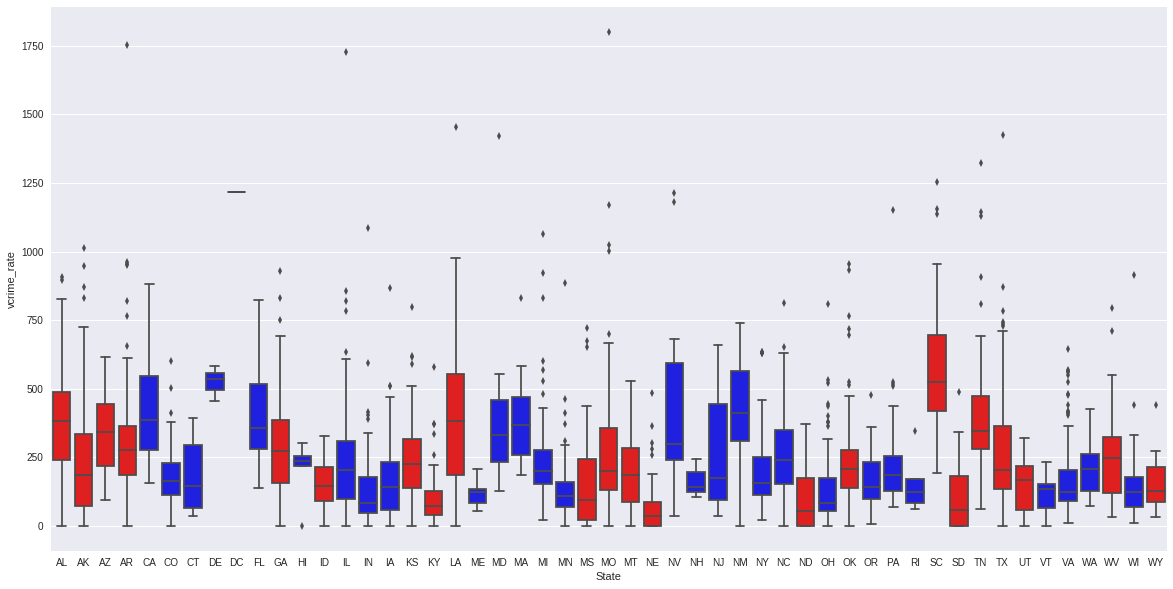

In [11]:
# According to the 2008 presidential election
blue_states =['WA', 'OR', 'CA', 'NV', 'NM', 'CO', 'MN', 'IA', 'WI', 'IL', 'IN', 'MI', 'OH', 'PA', 'NY', 'VT', 'NH', 'ME', 'MA', 'CT', 'RI', 'NJ', 'DE', 'MD', 'VA', 'NC', 'FL', 'HI']
red_states = ['ID', 'MT', 'WY', 'UT', 'AZ', 'ND', 'SD', 'NE', 'KS', 'OK', 'TX', 'MO', 'AR', 'LA', 'WV', 'KY', 'TN', 'MS', 'AL', 'GA', 'SC', 'AK']
fix, ax = plt.subplots(figsize=(20,10))
pal = {state: 'r' if state in red_states else "b" for state in df.State}
sns.boxplot(ax=ax, x='State', y='vcrime_rate', data=df, palette=pal)

Box plot of percentages without a highschool diploma

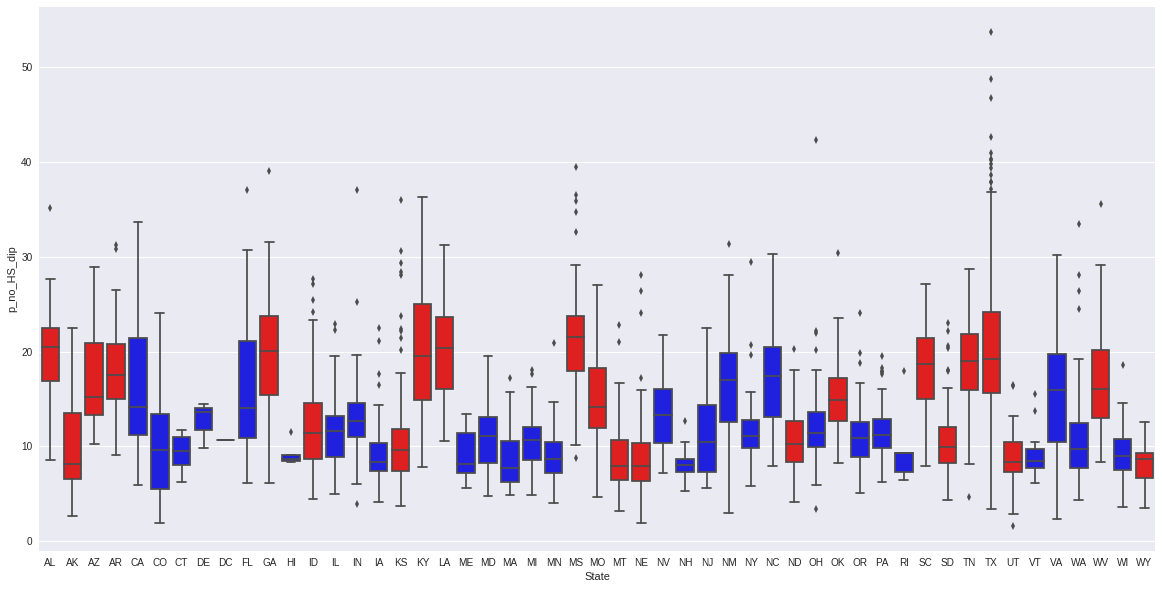

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(ax=ax, x='State', y='p_no_HS_dip', data=df, palette=pal)

Graphs of factors to violent crime

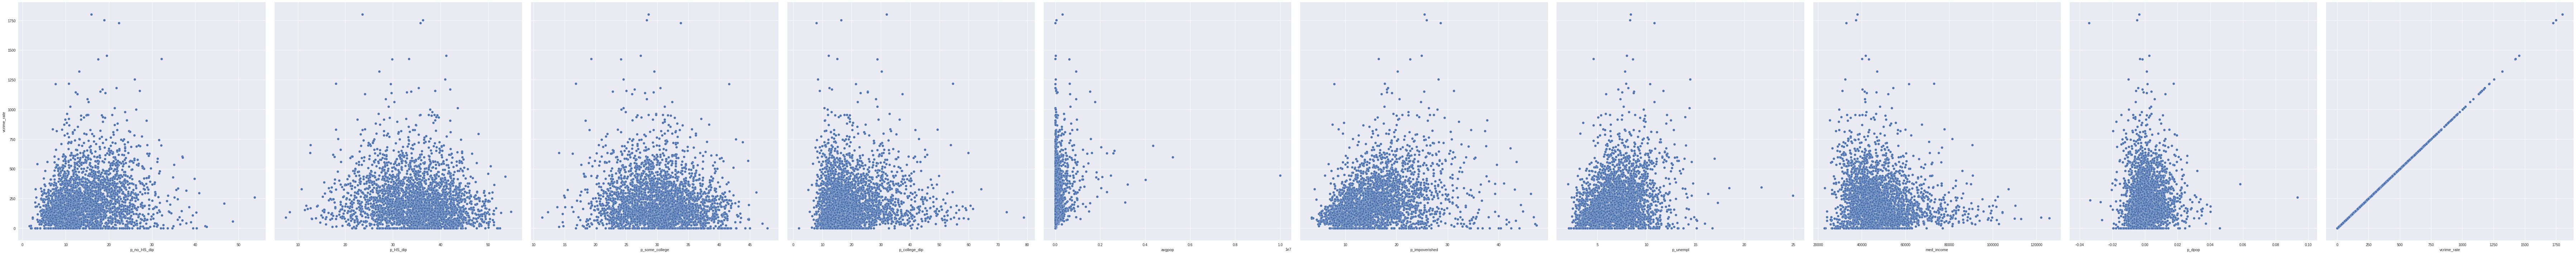

In [13]:
sns.pairplot(df, y_vars=['vcrime_rate'], x_vars=['p_no_HS_dip', 'p_HS_dip', 'p_some_college', 'p_college_dip', 'avgpop',
   'p_impoverished', 'p_unempl', 'med_income', 'p_dpop', 'vcrime_rate'], dropna=True, size=10)

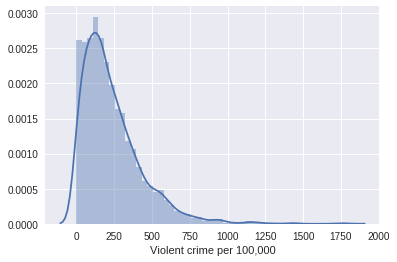

In [14]:
sns.distplot(df.vcrime_rate.dropna(), axlabel="Violent crime per 100,000")

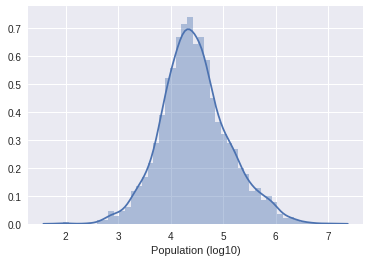

In [15]:
sns.distplot(df.avgpop.dropna().apply(np.log10), axlabel="Population (log10)")

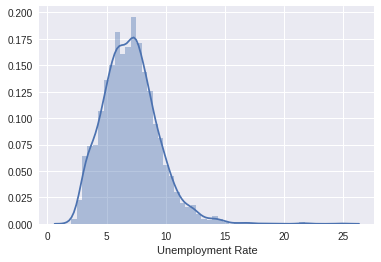

In [16]:
sns.distplot(df.p_unempl.dropna(), axlabel='Unemployment Rate')

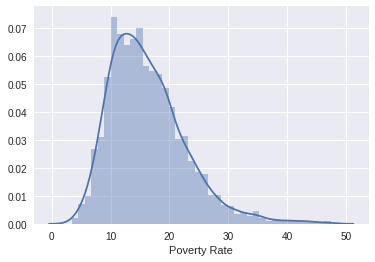

In [17]:
sns.distplot(df.p_impoverished.dropna(), axlabel="Poverty Rate")

We want to select counties that have similar violent crime factors. For example, we don't want to end up comparing a well-to-do city in the suburbs of Maine against skid-row L.A.

First we bin the data into high, medium and low (based on national quantiles)

In [18]:
binned = pd.DataFrame({c : pd.qcut(df[c], 3, labels=['L', 'M', 'H']) for c in df.drop(['State', 'County', 'COVIND'], axis=1).columns}).join(df[['State', 'County', 'COVIND']])

Here is a table of the five worst counties in Texas (based on high rates of unemployment, crime, and population. Half of them are border towns with immigration problems

In [19]:
TX = binned.dropna(how='all').groupby(['vcrime_rate', 'p_unempl', 'avgpop'])
display(df.loc[TX.get_group(('H', 'H', 'H')).index].where(df.State == 'TX').dropna())

,State,County,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
FIPS,,,,,,,,,,,,,
48215,TX,Hidalgo County,37.9,23.2,22.1,16.7,816500.571429,31.1,9.29,35441.0,100.0,0.013135,316.595002
48245,TX,Jefferson County,17.0,33.3,31.3,18.4,252962.142857,16.9,8.84,47620.0,100.0,0.001356,709.197028
48291,TX,Liberty County,23.8,38.0,28.6,9.6,77840.857143,15.8,8.42,53552.0,100.0,0.011127,444.496647
48323,TX,Maverick County,40.9,22.4,25.9,10.7,56273.428571,23.9,12.33,34687.0,100.0,0.008700,296.765284
48361,TX,Orange County,11.2,40.0,34.2,14.6,83306.000000,16.1,8.67,51156.0,100.0,0.005362,354.116150


Graph of how Texas matches up nationwide to crime

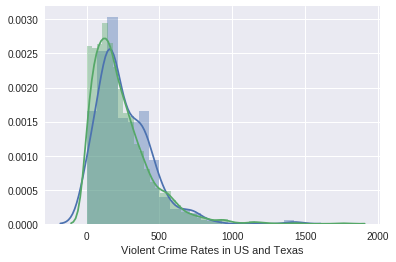

In [20]:
sns.distplot(df.where(df.State=='TX').vcrime_rate.dropna(), label="Violent Crime Rates in Texas")
sns.distplot(df.vcrime_rate.dropna(), axlabel="Violent Crime Rates in US and Texas")

Table of the highest crime rates in the US with at least a population of 10000 to cull outliers. 

Note that high city crime does not necessarily match high county crime. For example, Chicago is a high crime city, but because it's split between two counties it's ranked lower on this list. St. Louis, however, is both a city and its own county, so it's data is more precise

In [21]:
display(df.where(df.avgpop > 10000).sort_values('vcrime_rate', ascending=False)[:20])

,State,County,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
FIPS,,,,,,,,,,,,,
29510,MO,St. Louis city,15.9,23.6,28.6,31.9,3.169429e+05,25.5,8.41,37948.0,100.0000,-0.003596,1800.324529
5035,AR,Crittenden County,18.9,36.3,28.3,16.4,4.986000e+04,25.9,8.31,37371.0,100.0000,-0.004776,1750.902527
22031,LA,De Soto Parish,19.5,41.2,27.3,12.1,2.695600e+04,24.9,8.01,41691.0,100.0000,0.002613,1454.221695
24510,MD,Baltimore city,17.5,29.8,24.1,28.7,6.210013e+05,22.7,8.62,43192.0,100.0000,-0.001490,1422.058247
47157,TN,Shelby County,13.1,27.1,29.5,30.2,9.352307e+05,20.2,7.82,46998.0,100.0000,0.001057,1320.957472
45069,SC,Marlboro County,26.0,41.0,24.5,8.5,2.798357e+04,28.2,14.47,32485.0,100.0000,-0.010149,1254.307374
11001,DC,District of Columbia,10.7,18.0,16.8,54.6,6.458149e+05,17.7,7.91,73115.0,100.0000,0.017565,1217.996135
29201,MO,Scott County,18.5,42.0,26.3,13.2,3.904900e+04,18.1,7.13,40285.0,100.0000,-0.001617,1170.324464
45033,SC,Dillon County,27.1,38.9,25.0,9.0,3.146329e+04,31.2,11.71,31094.0,100.0000,-0.005467,1156.903965


We grouped the data by violent crime rate, poverty rate, unemployment rate, and population.

We select counties with high rates of enemployment, violent crime, poverty, and large populations sampled using a nonrandom seed for consistency between runs.

In [22]:
# all counties grouped by H/M/L rates of each factor
groups = ['vcrime_rate', 'p_impoverished', 'p_unempl', 'avgpop']

c = binned.dropna(how='all').groupby(groups[::-1])
display(c.count().where(c.count().State > 10).dropna().sort_values('State', ascending=False)['State'].unstack())

vcrime_rate                         H      L     M
avgpop p_unempl p_impoverished                    
H      H        H                89.0   11.0  21.0
                L                 NaN    NaN  18.0
                M                87.0   12.0  43.0
       L        H                16.0    NaN   NaN
                L                37.0   59.0  93.0
                M                47.0    NaN  21.0
       M        H                68.0    NaN  27.0
                L                41.0   46.0  79.0
                M               106.0   17.0  74.0
L      H        H                85.0   91.0  44.0
                M                14.0   34.0  28.0
       L        H                12.0   15.0  23.0
                L                29.0  210.0  77.0
                M                12.0   92.0  42.0
       M        H                28.0   28.0  40.0
                L                11.0   24.0  13.0
                M                14.0   34.0  23.0
M      H        H               153.0   60.0  73.0
                L                 NaN   18.0   NaN
                M                29.0   41.0  48.0
       L        L                21.0   81.0  51.0
                M                24.0   17.0  39.0
       M        H                54.0   23.0  46.0
                L                11.0   60.0  37.0
                M                35.0   39.0  61.0

In [23]:

selection = ('H','H','H', 'H')
for x in groups:
    print("%10s " %x[:10], end='')
print('')
for x in selection:
    print("%10s " %x[:10], end='')
HHHstates = df.loc[c.get_group(selection).index]
display(HHHstates.where(HHHstates.vcrime_rate > 800).dropna().sample(10, random_state=15))

vcrime_rat p_impoveri   p_unempl     avgpop 
         H          H          H          H 

,State,County,p_no_HS_dip,p_HS_dip,p_some_college,p_college_dip,avgpop,p_impoverished,p_unempl,med_income,COVIND,p_dpop,vcrime_rate
FIPS,,,,,,,,,,,,,
42101,PA,Philadelphia County,18.0,33.8,22.8,25.4,1.552449e+06,25.4,8.74,41210.0,100.0000,0.003853,1150.827067
13095,GA,Dougherty County,19.1,29.3,32.8,18.9,9.301957e+04,29.4,9.34,34799.0,100.0000,-0.006985,929.911831
47157,TN,Shelby County,13.1,27.1,29.5,30.2,9.352307e+05,20.2,7.82,46998.0,100.0000,0.001057,1320.957472
39095,OH,Lucas County,11.6,31.2,32.9,24.2,4.364534e+05,19.5,8.26,43136.0,100.0000,-0.003053,810.624861
5069,AR,Jefferson County,15.2,38.7,28.6,17.5,7.361114e+04,26.5,8.84,36990.0,100.0000,-0.014398,953.659966
26163,MI,Wayne County,15.3,30.3,32.4,22.0,1.779158e+06,24.8,10.83,41585.0,99.6046,-0.005723,1062.862406
24510,MD,Baltimore city,17.5,29.8,24.1,28.7,6.210013e+05,22.7,8.62,43192.0,100.0000,-0.001490,1422.058247
26049,MI,Genesee County,10.7,32.8,37.1,19.3,4.160401e+05,20.5,9.80,44181.0,98.5058,-0.005897,921.305327
5035,AR,Crittenden County,18.9,36.3,28.3,16.4,4.986000e+04,25.9,8.31,37371.0,100.0000,-0.004776,1750.902527


From those counties, we selected the county seats as the cities
We looked up the latitude and longitude of them to match to NOAA's list of weather stations. We used Pythagoras' theorem to find the closest station to the city, as some cities may not have one within city limits.

In [24]:
cities = {
    'Philidelphia, PA' : (39.9526, -75.1652), #Philadelphia County
    'Albany, GA' : (31.5785, -84.1557), # Gougherty County
    'Memphis, TN' : (35.1495, -90.0490), # Shelby County and Crittenden County
    'Toledo, OH' : (41.6639, -83.5552), # Lucas County
    'Pine Bluff AR' : (34.2284, -92.0032), # Jefferson County
    'Detroit, MI' : (42.3314, -83.0458), # Wayne County
    'Baltimore, MD' : (39.2904, -76.6122), # Baltimore City
    'Flint, MI' : (43.0125, -83.6875), # Genesee County
    'St. Louis, MO' : (38.6270, -90.1994) # St. Louis City
}

Then we cross-referenced those locations with the NOAA ISD dataset to find the nearest stations.

The stations were filtered such that we only selected stations that had recent (more recent than 2012) data.

In [25]:
# list of stations with location, name, and recording beginning and end dates
hist = pd.read_csv('ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv')
# only recent stations
hist = hist.where(hist.END > 20120101 ).dropna(how='all')

We defined some helper functions to process the station codes

In [26]:
def dist(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [27]:
def format_station_code(usaf, wban):
    usafstr = str(int(usaf))
    wbanstr = str(int(wban))
    
    if len(usafstr) < 6:
        usafstr = '0'*(6-len(usafstr)) + usafstr
        
    if len(wbanstr) < 5:
        wbanstr = '0'*(5-len(wbanstr)) + wbanstr
        
    return usafstr + '-' + wbanstr

In [28]:
stations = dict()
for city in cities.keys():
    coord = cities[city]
    mindist = 999
    minindex = 0
    for index, row in hist.iterrows():
        d = dist(coord, (row['LAT'], row['LON']))
        if (d < mindist):
            mindist = d
            minindex = index
    print('Nearest ({:^6.2f}) ISD to {:20} is {:40} at loc {}'.format(mindist, city, hist.loc[minindex]['STATION NAME'], minindex))
    stations[city] = format_station_code(hist.loc[minindex]['USAF'], hist.loc[minindex]['WBAN'])
    print('\tStation code is {}'.format(stations[city]))

Nearest ( 0.10 ) ISD to Philidelphia, PA     is PHILADELPHIA INTERNATIONAL AIRPORT       at loc 19409
	Station code is 724080-13739
Nearest ( 0.06 ) ISD to Albany, GA           is SW GEORGIA REGIONAL ARPT                 at loc 18172
	Station code is 722160-13869
Nearest ( 0.11 ) ISD to Memphis, TN          is MEMPHIS INTERNATIONAL AIRPORT            at loc 19083
	Station code is 723340-13893
Nearest ( 0.12 ) ISD to Toledo, OH           is TOLEDO SUBURBAN AIRPORT                  at loc 17128
	Station code is 720275-04872
Nearest ( 0.09 ) ISD to Pine Bluff AR        is GRIDER FIELD AIRPORT                     at loc 19109
	Station code is 723417-93988
Nearest ( 0.09 ) ISD to Detroit, MI          is DETROIT CITY AIRPORT                     at loc 20166
	Station code is 725375-14822
Nearest ( 0.01 ) ISD to Baltimore, MD        is BALTIMORE DOWNTOWN                       at loc 21807
	Station code is 745944-93784
Nearest ( 0.08 ) ISD to Flint, MI            is BISHOP INTERNATIONAL AIRPORT

## Data Acquisition <a class="anchor" id="acquisition"></a>

[Back to Table of Contents](#toc)

Next we need to download the crime data for each city. We used SpotCrime to get the information, but we had to scrape their website.

First lets define some helper functions to download crime data

In [29]:
def get_soup(city):
    """Returns BeautifulSoup object for each set of links"""
    r = requests.get('https://spotcrime.com/' + city + 'daily')
    r2 = requests.get('https://spotcrime.com/' + city + 'daily/more')
    soup1 = BeautifulSoup(r.text, 'html.parser')
    soup2 = BeautifulSoup(r2.text, 'html.parser')
    
    return soup1, soup2

In [30]:
def get_links(soups):
    """Pulls all the links from each BeautifulSoup object into a single list"""
    links = []
    for dates in soups[0].find_all('ol', class_='list-unstyled'):
        for link in dates.find_all('a'):
            links.append(link['href'])
    for dates in soups[1].find_all('ol', class_='list-unstyled'):
        for link in dates.find_all('a'):
            links.append(link['href'])
    return links

In [31]:
def crime_df(links, base_url):
    """Loads each link and downloads the table of crimes, storing it in a list of lists
    Returns a dataframe
    """
    data = []
    for i, link in enumerate(links):
        print(i, link)
        try:
            r = requests.get(base_url + link)
        except:
            print('uh oh, timeout')
            time.sleep(10)
            r = requests.get(base_url+link)

        soup = BeautifulSoup(r.text, 'html.parser')
        table = soup.find('table')
        if table == None:
            print('no table, skipping')
            continue
        rows = table.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            crime = [ele for ele in cols if ele]
            if len(crime) == 0:
                continue
            if len(crime) == 4:
                crime = ['A'] + crime
            data.append(crime)
    return pd.DataFrame(data, columns=['A', 'Crime', 'Time', 'Address', 'Details'])

In [32]:
base_url = 'https://spotcrime.com'
cities = [
    'mi/detroit/',
    'mo/st.+louis/',
    'md/baltimore/',
    'oh/toledo/',
    'ga/albany/',
    'mi/flint/',
    'tn/memphis/',
    'pa/philadelphia/',
]

Next we'll download all the crime data for each city and save it to a gzipped csv file in the data folder

In [33]:
if PROCESS_FULLY:
    for city in cities:
        soup1, soup2 = get_soup(city)

        links = get_links((soup1, soup2))
        df = crime_df(links, base_url)
        df = df.drop(['A', 'Address', 'Details'], axis=1)
        df.to_csv('../data/crime_{}_{}.csv.gz'.format(city[3:-1], city[:2]), compression='gzip', index=False)

For ease of use, we defined a class to hold the city datasets

In [34]:
class City:
    """Class representing each city
    
    Attributes:
        name (str): Name of the city City, 2-letter State
        filepath (str): Filepath for the crime data
        isd_code (str): Code for NOAA's ISD. Composed of USAF-WBAN id
        dfc (DataFrame): Dataframe holding all crime data for the city
        dfv (DataFrame): Dataframe holding only violent crime for the city
        dfw (DataFrame): Dataframe holding weather data for the city
        df (Dataframe) : Dataframe holding the merged weather+violentcrime data
        all_crime (DataFrame): Alias for dfc
        violent_crime (DataFrame): Alias for dfv
        weather (Dataframe): Alias for dfw
        
    """
    
    def __init__(self, name, filepath, isd_code):
        self.name = name
        self.filepath = filepath
        self.isd_code = isd_code
    
    def load_crime(self, process=True):
        """Reads crime dataset from filepath and stores in dfc and dfv
        
        Args:
            process (bool): Whether to immediately or lazily process the data
                Defaults to true, process the data
        
        Returns:
            self
        """
        self.dfc = pd.read_csv(self.filepath, compression='gzip')
        self.dfv = self.dfc.where(self.dfc.Crime.isin(['Assault', 'Robbery', 'Shooting'])).dropna()
        self.all_crime = self.dfc
        self.violent_crime = self.dfv
        if process: 
            return self.process_crime()
        
        return self
    
    def process_crime(self, how='Fast'):
        """Processes the crime by converting the dates to datetime dtypes
        
        Args:
            how (str): How to process the crime. Fast method drops data that doesn't
                            specify the time of day, and is in general faster
                            
        Returns:
            self
            
        """
        if how == 'Fast':
            self.dfc.Time = pd.to_datetime(self.dfc.Time, 
                                           format='%m/%d/%y. %I:%M %p.', 
                                           errors='coerce').dropna()
            self.dfc = self.dfc[self.dfc.Time.notnull()]
        else:
            self.dfc.Time = pd.to_datetime(self.dfc.Time, errors='coerce')
            
        self.dfc = self.dfc.set_index('Time')
        self.dfv = self.dfc.where(self.dfc.Crime.isin(['Assault', 'Robbery', 'Shooting', 'Arson'])).dropna()
        self.all_crime = self.dfc
        self.violent_crime = self.dfv
        
        return self
        
    def load_weather(self, start=2016, end=2018):
        """Loads weather over FTP from NOAA's website into dfw
        
        Args:
            start (int): Start year 
            end (int): End year
            
        Returns:
            self
        
        """
        self.dfw = noaa.noaa_from_web(self.isd_code, start, end).fillna(method='backfill')
            
        # drop relative humididty 
        self.dfw = self.dfw.drop('RHPeriod', axis = 1)
        
        # replace null values
        self.dfw['Temperature'] = self.dfw['Temperature'].replace(9999,np.nan)
        self.dfw['Pressure'] = self.dfw['Pressure'].replace(99999,np.nan)
        self.dfw['Humidity'] = self.dfw['Humidity'].replace(999, np.nan)
        self.dfw['Sky'] = self.dfw['Sky'].replace([9,99], np.nan)
        
        # scale values back
        self.dfw['Temperature'] = self.dfw['Temperature'].map(lambda x : x/10)
        self.dfw['Pressure'] = self.dfw['Pressure'].map(lambda x : x/10)
        
        # map sky oktas to coverage percentages, roughly
        self.dfw['Sky'] = self.dfw['Sky'].map(lambda x : x/8)
        
        # convert C to F
        self.dfw['Temperature'] = self.dfw['Temperature'].map(lambda x : x * 9/5 + 32)
        self.weather = self.dfw
        
        return self
        
    def merge_dfs(self, start='2016-01-01', end='2017-01-01'):
        """Merges violent crime and weather into a single dataset, df, cut into a range
        
        Args:
            start (date string): Start date to cut
            end (date string): End date to cut to
            
        Returns:
            Self
        
        """
        self.df = self.dfw.join(self.dfv, how='outer')
        self.df = self.df.groupby( 
                        [self.df.index.year, 
                         self.df.index.month, 
                         self.df.index.day, 
                         self.df.index.hour]
                    ).agg ({   
                         'Temperature' : 'mean', 
                         'Pressure' : 'mean',
                         'Humidity' : 'mean',
                         'Sky' : 'mean',
                         'Crime' : 'count'}
                    ).reset_index().rename(columns={
                        'level_0':'year',
                        'level_1':'month',
                        'level_2':'day',
                        'level_3':'hour',
                    })
        s = pd.to_datetime(self.df[['year', 'month', 'day', 'hour']])
        self.df = self.df.set_index(s).drop(['year', 'month', 'day', 'hour'], 
                                    axis=1)
        
        self.df = self.df.loc[self.df.index > start]
        self.df = self.df.loc[self.df.index < end]

        return self

A dictionary to hold all the city classes, initialized but not loaded

In [57]:
cities = {
    ##'Albany, GA': City('Albany, GA', '../data/crime_albany_ga.csv.gz', '722160-13869'),
    ## Not enough data for Albany
    'Baltimore, MD': City('Baltimore, MD', '../data/crime_baltimore_md.csv.gz', '745944-93784'),
    'Detroit, MI': City('Detroit, MI', '../data/crime_detroit_mi.csv.gz', '725375-14822'),
    'Flint, MI': City('Flint, MI', '../data/crime_flint_mi.csv.gz', '726370-14826'),
    'Memphis, TN': City('Memphis, TN', '../data/crime_memphis_tn.csv.gz', '723340-13893'),
    'Philadelphia, PA': City('Philadelphia, PA', '../data/crime_philadelphia_pa.csv.gz', '724080-13739'),
    ##'Pine Bluff AR': 
    ## no data for Pine Bluff
    'St. Louis, MO': City('St. Louis, MO', '../data/crime_st.+louis_mo.csv.gz', '725314-03960'),
    'Toledo, OH': City('Toledo, OH', '../data/crime_toledo_oh.csv.gz', '720275-04872')
}

Load the crime data into the classes

In [58]:
for city in cities.values():
    city.load_crime().load_weather(start=2014, end=2017).merge_dfs(start='2014-01-01', end='2017-01-01')

## Data Analysis <a class="anchor" id="analysis"></a>

[Back to Table of Contents](#toc)

Now that we've loaded all out data, we can begin to analyse the data. First let's define some hypotheses.

### Hypotheses <a class="anchor" id="hypothesis"></a>
* Temperature is positively correlated with the violent crime rates (Richard)
* Humidity and pressure have no impact on violent crime
* Violent crime is higher in summer vs winter (Lalo)
* Violent crime is higher during midnight hours (11:00pm - 2:00am) (Lexi)
* Is there a spike in total crime at 2:00AM because bars close? (Laxo)

[Back to Table of Contents](#toc)

### Exploration <a class="anchor" id="exploration"></a>

[Back to Table of Contents](#toc)

We need to explore the data first.

There are two ways to parse the time, by dropping non-listed times or converting them to default to 00:00. We chose to use by default dropping incomplete data, but we wanted to have a metric of how much data we lost.

Below is a comparison of the amount of entries lost as a percentage of the whole for each city, along with the times required to parse it. Dropping dates is considerably faster.

Because of the amount of lost data, we chose to particularly examine Philadelphia and Memphis.

In [59]:
if PROCESS_FULLY:
    datalosses = pd.DataFrame()

    for city in cities.values():
        print(city.name)

        city.load_crime(False)
        t1 = time.time()
        city.process_crime(how='Slow')
        t2 = time.time()
        slow = t2 - t1
        df1 = city.dfc

        city.load_crime(False)
        t1 = time.time()
        city.process_crime(how='Fast')
        t2 = time.time()
        fast = t2-t1
        df2 = city.dfc

        print('Slow: {} Fast: {}'.format(slow, fast))
        datalosses[city.name] = df2.Crime.value_counts()/df1.Crime.value_counts()

    datalosses

Below is a quick correlation of temperature on the X axis and violent crime incidences on the hour measured at that tempreature on the Y axis. There is somewhat of a positive correlation between the largest values in some cities, but it's completely swamped on the lower end by low values.

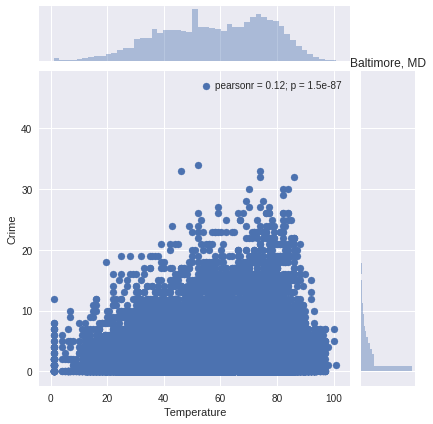

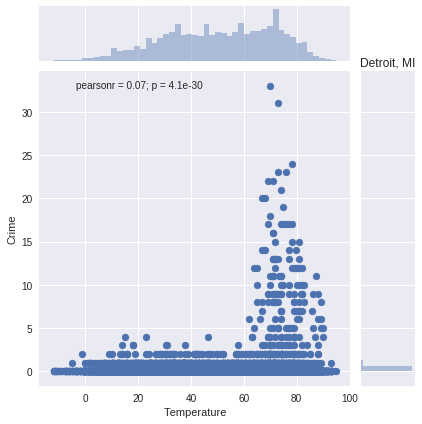

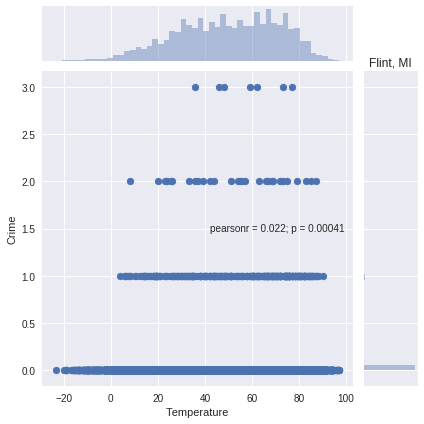

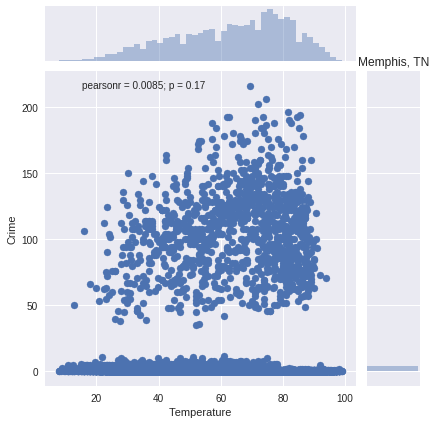

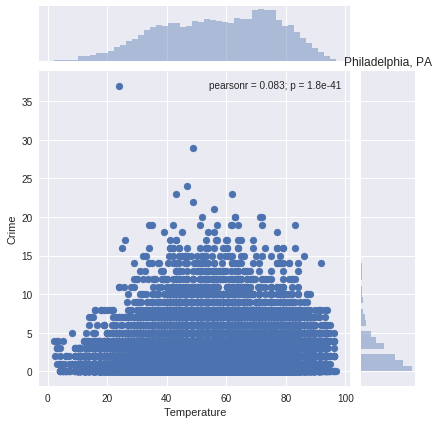

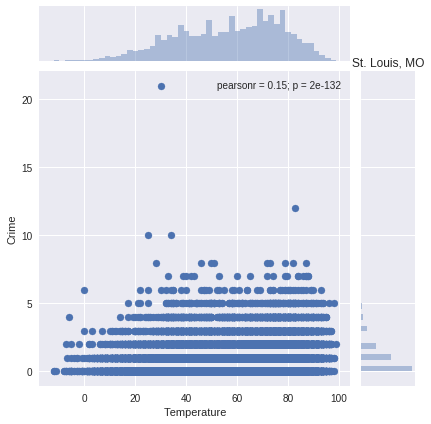

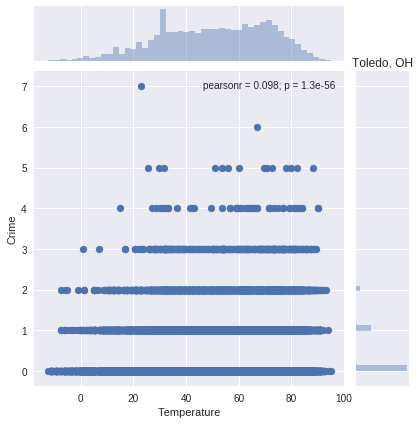

In [60]:
for city in cities.values():
    df = city.df[['Temperature', 'Crime']].dropna()
    sns.jointplot(x='Temperature', y='Crime', data=df)
    plt.title(city.name)

A distribution of the amounts of violent crimes in each city

Baltimore, MD


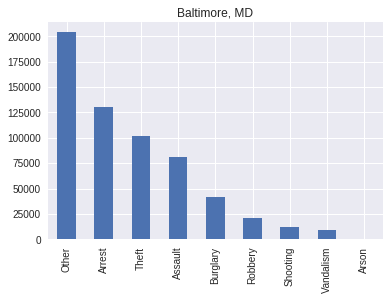

Detroit, MI


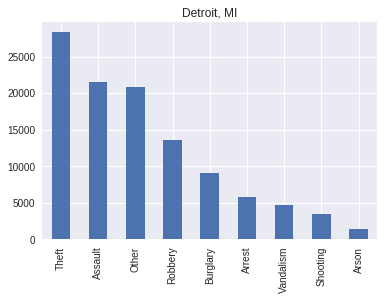

Flint, MI


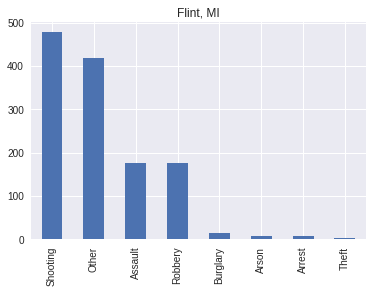

Memphis, TN


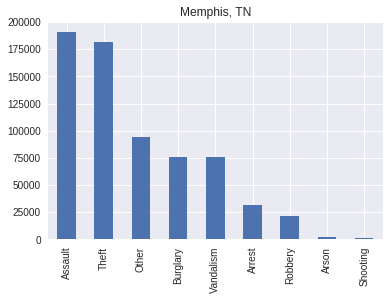

Philadelphia, PA


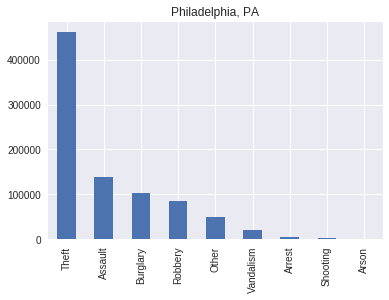

St. Louis, MO


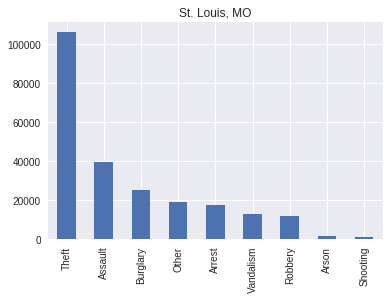

Toledo, OH


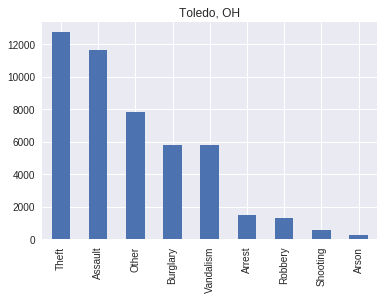

In [61]:
for city in cities.values():
    print(city.name)
    city.dfc.Crime.value_counts().plot(kind='bar')
    plt.title(city.name)
    plt.show()

Perhaps there is a correlation between the day of the week and criminal activity. Perhaps on the weekend, with more free time, criminals may become violent instead of working at their jobs.

There does not appear to be a correlation

In [62]:
phili = cities['Philadelphia, PA']

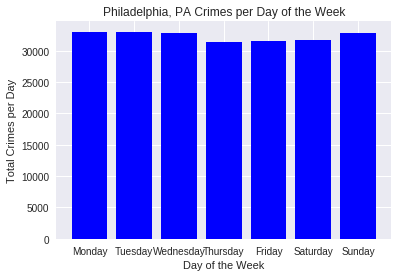

In [63]:
# this is a hack
d = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday': 4 , 'Saturday' : 5, 'Sunday' : 6}

# Philadelphia, PA
df4 = phili.dfv
days = {}
for val in df4.index:
    day = calendar.day_name[val.weekday()]
    days[day] = days.get(day, 0) + 1
sorted_days = [w for w in sorted(days.items(), key=lambda x: d[x[0]])]
plt.bar(range(len(days)), [day[1] for day in sorted_days], align = 'center', color = 'b')
plt.xticks(range(len(days)), [day[0] for day in sorted_days])
plt.title('Philadelphia, PA Crimes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Crimes per Day')
plt.show()

It may be worthwhile to examine the total crime, and not violent crime for weekend activity.

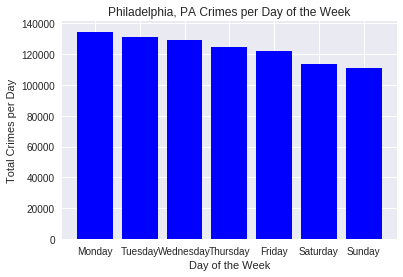

In [64]:
# this is a hack
d = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday': 4 , 'Saturday' : 5, 'Sunday' : 6}

# Philadelphia, PA
df4 = phili.dfc
days = {}
for val in df4.index:
    day = calendar.day_name[val.weekday()]
    days[day] = days.get(day, 0) + 1
sorted_days = [w for w in sorted(days.items(), key=lambda x: d[x[0]])]
plt.bar(range(len(days)), [day[1] for day in sorted_days], align = 'center', color = 'b')
plt.xticks(range(len(days)), [day[0] for day in sorted_days])
plt.title('Philadelphia, PA Crimes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Crimes per Day')
plt.show()

There appears to be a tendency to commit crimes during the week. Since this includes burglary and theft, this may be because criminals are more likely to commit crimes when they know their victim are away at work or school.

### Hypothesis 1: Violent crime is correlated with higher temperatures 

We want to see how violent crime is correlated with temperature. We can find the mean temperature of a city, and posit that when the temperature is unusually high (greater than 1 standard deviation), the amount of crimes are also higher.

* let p = the average crimes per hour in a city in a sample with higher temperature than average
* let mu be the average crimes per hour over a year
* let h_0 : p = mu and h_a : p > mu

In [65]:
mu = phili.df.Crime.mean()
n = 100
p0 = mu
stdtemp = phili.df.Temperature.std()
tempmu = phili.df.Temperature.mean()
alpha = 0.01

# Select only days which are greater than 1 std from the mean
sample = phili.df.Crime[phili.df.Temperature > tempmu + 1 * stdtemp].sample(n, random_state=57)
p = sample.mean()

S = stats.tstd(sample)
z = (p-p0)/(S/np.sqrt(n))
z_alpha = stats.norm().ppf(1-alpha)


if z > z_alpha:
    print("Since Z={0:4.2f} > Z_alpha={1:4.2f}, in Philadelpha can we reject H_0".format(z, z_alpha))
else :
    print("Since Z={0:4.2f} < Z_alpha={1:4.2f}, in Philadelpha we cannot reject H_0".format(z, z_alpha))

Since Z=0.82 < Z_alpha=2.33, in Philadelpha we cannot reject H_0


What about for abnormally low temperatures?

In [66]:
mu = phili.df.Crime.mean()
n = 100
p0 = mu
stdtemp = phili.df.Temperature.std()
tempmu = phili.df.Temperature.mean()
alpha = 0.01

# Select only days which are greater than 1 std from the mean
sample = phili.df.Crime[phili.df.Temperature > tempmu - 1 * stdtemp].sample(n, random_state=57)
p = sample.mean()

S = stats.tstd(sample)
z = (p-p0)/(S/np.sqrt(n))
z_alpha = stats.norm().ppf(1-alpha)


if z > z_alpha:
    print("Since Z={0:4.2f} > Z_alpha={1:4.2f}, in Philadelpha can we reject H_0".format(z, z_alpha))
else :
    print("Since Z={0:4.2f} < Z_alpha={1:4.2f}, in Philadelpha we cannot reject H_0".format(z, z_alpha))

Since Z=0.78 < Z_alpha=2.33, in Philadelpha we cannot reject H_0


### Hypothesis 2: Violent crime is not correlated with humidity or pressure

Let's try to compare violent crime with abnormal pressure

* let p = the average crimes per hour in a city in a sample with higher or lower pressure than average
* let mu be the average crimes per hour over a year
* let h_0 : p = mu and h_a : p > mu

In [67]:
mu = phili.df.Crime.mean()
n = 100
p0 = mu
stdpressure = phili.df.Pressure.std()
pressuremu = phili.df.Pressure.mean()
alpha = 0.01
half_alpha = alpha/2

# Select only days which are greater than 1 std from the mean
sample = phili.df.Crime[(phili.df.Pressure > pressuremu + 1 * stdpressure) | (phili.df.Pressure < mu - 1 * stdpressure)].sample(n, random_state=57)
p = sample.mean()

S = stats.tstd(sample)
z = (p-p0)/(S/np.sqrt(n))
z_half_alpha = stats.norm().ppf(1-half_alpha)


if np.abs(z) > z_half_alpha:
    print("Since |Z|={0:4.2f} > Z_half_alpha={1:4.2f}, in Philadelpha can we reject H_0".format(z, z_half_alpha))
else :
    print("Since |Z|={0:4.2f} < Z_half_alpha={1:4.2f}, in Philadelpha we cannot reject H_0".format(z, z_half_alpha))

Since |Z|=0.68 < Z_half_alpha=2.58, in Philadelpha we cannot reject H_0


What about humidity?

* let p = the average crimes per hour in a city in a sample with higher humidity than average
* let mu be the average crimes per hour over a year
* let h_0 : p = mu and h_a : p > mu

In [68]:
mu = phili.df.Crime.mean()
n = 100
p0 = mu
stdhu = phili.df.Humidity.std()
humu = phili.df.Humidity.mean()
alpha = 0.01

# Select only days which are greater than 1 std from the mean
sample = phili.df.Crime[phili.df.Temperature > humu + 1 * stdhu].sample(n, random_state=57)
p = sample.mean()

S = stats.tstd(sample)
z = (p-p0)/(S/np.sqrt(n))
z_alpha = stats.norm().ppf(1-alpha)


if z > z_alpha:
    print("Since Z={0:4.2f} > Z_alpha={1:4.2f}, in Philadelpha can we reject H_0".format(z, z_alpha))
else :
    print("Since Z={0:4.2f} < Z_alpha={1:4.2f}, in Philadelpha we cannot reject H_0".format(z, z_alpha))

Since Z=0.15 < Z_alpha=2.33, in Philadelpha we cannot reject H_0


One of the references suggested that dryer days correlate with more crime

In [69]:
mu = phili.df.Crime.mean()
n = 100
p0 = mu
stdhu = phili.df.Humidity.std()
humu = phili.df.Humidity.mean()
alpha = 0.01

# Select only days which are greater than 1 std from the mean
sample = phili.df.Crime[phili.df.Temperature < humu - 1 * stdhu].sample(n, random_state=57)
p = sample.mean()

S = stats.tstd(sample)
z = (p-p0)/(S/np.sqrt(n))
z_alpha = stats.norm().ppf(1-alpha)


if z > z_alpha:
    print("Since Z={0:4.2f} > Z_alpha={1:4.2f}, in Philadelpha can we reject H_0".format(z, z_alpha))
else :
    print("Since Z={0:4.2f} < Z_alpha={1:4.2f}, in Philadelpha we cannot reject H_0".format(z, z_alpha))

Since Z=-1.30 < Z_alpha=2.33, in Philadelpha we cannot reject H_0


### Hypothesis 3: Violent crime is higher in summer than in winter

[Back to Table of Contents](#toc)

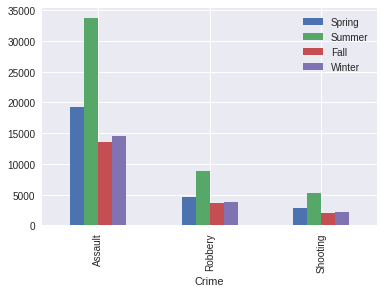

In [70]:
blt = cities['Baltimore, MD']
blt.load_crime().load_weather().merge_dfs()
seasonalDFV = blt.dfv

springStartMonth = 3
springEndMonth = 5

summerStart = 6
summerEnd = 9
fallStart = 10
fallEnd = 11
winterStart =12
winterEnd = 3


SpringMask = (seasonalDFV.index.month >= springStartMonth) & (seasonalDFV.index.month <= springEndMonth) 
summerMask =(seasonalDFV.index.month >= summerStart ) & (seasonalDFV.index.month <= summerEnd)
fallMask= (seasonalDFV.index.month >= fallStart) & (seasonalDFV.index.month <= fallEnd)
wintMask = (seasonalDFV.index.month < winterEnd) | (seasonalDFV.index.month >= winterStart) 

winterDF = pd.DataFrame(seasonalDFV.loc[wintMask].Crime.value_counts())
springDF = pd.DataFrame(seasonalDFV.loc[SpringMask].Crime.value_counts())
summerDF = pd.DataFrame(seasonalDFV.loc[summerMask].Crime.value_counts())
fallDF = pd.DataFrame(seasonalDFV.loc[fallMask].Crime.value_counts())

#winterDF = winterDF.drop('Arson')
springDF = springDF.drop('Arson')
summerDF = summerDF.drop('Arson')
fallDF = fallDF.drop('Arson')

winterDF = winterDF.rename(columns={'Crime':'Winter'})
summerDF = summerDF.rename(columns={'Crime':'Summer'})
springDF = springDF.rename(columns={'Crime':'Spring'})
fallDF = fallDF.rename(columns={'Crime':'Fall'})

fallDF = fallDF.merge(winterDF, left_index=True, right_index=True,how='left')
springDF = springDF.merge(summerDF,left_index=True,right_index=True,how='left')
springDF = springDF.merge(fallDF,left_index=True,right_index=True,how='left')
crimesCountBySeason = springDF
crimesCountBySeason.index.name = 'Crime'

crimesCountBySeason.plot.bar()

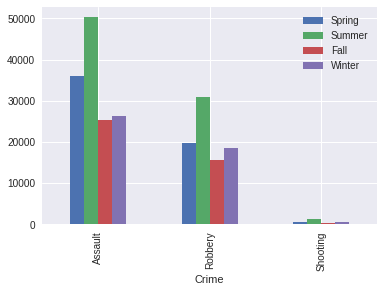

In [71]:
phili = cities['Philadelphia, PA']
phili.load_crime().load_weather().merge_dfs()
seasonalDFV = phili.dfv

springStartMonth = 3
springEndMonth = 5

summerStart = 6
summerEnd = 9
fallStart = 10
fallEnd = 11
winterStart =12
winterEnd = 3


SpringMask = (seasonalDFV.index.month >= springStartMonth) & (seasonalDFV.index.month <= springEndMonth) 
summerMask =(seasonalDFV.index.month >= summerStart ) & (seasonalDFV.index.month <= summerEnd)
fallMask= (seasonalDFV.index.month >= fallStart) & (seasonalDFV.index.month <= fallEnd)
wintMask = (seasonalDFV.index.month < winterEnd) | (seasonalDFV.index.month >= winterStart) 

winterDF = pd.DataFrame(seasonalDFV.loc[wintMask].Crime.value_counts())
springDF = pd.DataFrame(seasonalDFV.loc[SpringMask].Crime.value_counts())
summerDF = pd.DataFrame(seasonalDFV.loc[summerMask].Crime.value_counts())
fallDF = pd.DataFrame(seasonalDFV.loc[fallMask].Crime.value_counts())

#winterDF = winterDF.drop('Arson')
springDF = springDF.drop('Arson')
summerDF = summerDF.drop('Arson')
fallDF = fallDF.drop('Arson')

winterDF = winterDF.rename(columns={'Crime':'Winter'})
summerDF = summerDF.rename(columns={'Crime':'Summer'})
springDF = springDF.rename(columns={'Crime':'Spring'})
fallDF = fallDF.rename(columns={'Crime':'Fall'})

fallDF = fallDF.merge(winterDF, left_index=True, right_index=True,how='left')
springDF = springDF.merge(summerDF,left_index=True,right_index=True,how='left')
springDF = springDF.merge(fallDF,left_index=True,right_index=True,how='left')
crimesCountBySeason = springDF
crimesCountBySeason.index.name = 'Crime'

crimesCountBySeason.plot.bar()

### Hypothesis 4: violent crime is higher during the midnight hours of 11:00PM to 2:00AM

[Back to Table of Contents](#toc)

Here are the distribution based on the hour of Philadelphia. Are the crimes higher during midnight hours?

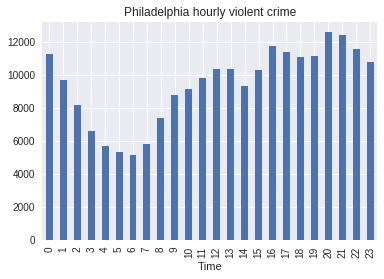

In [72]:
phili.dfv.Crime.groupby(phili.dfv.index.hour).count().plot(kind='bar')
plt.title("Philadelphia hourly violent crime")

If there is no correlation, there should be an equal number of crime at all hours. Because the midnight hours are 3 in total, they should occupy $$\frac{3}{24}$$ of the total crimes

Let p = percentage of crimes committed during the midnight hours

Let H_0 : p = 1/6, and H_a : p > 1/6

In [73]:
n = 1000
p0 = 1/6

sample = phili.dfv.sample(n, random_state=31)
midnight = sample.between_time(start_time='23:00', end_time='23:59')
midnight2 = sample.between_time(start_time='0:00', end_time='2:00')
midnight = midnight.count() + midnight2.count()

pHat = midnight.sum()/n
sigma = np.sqrt((p0 * (1-p0)/n))
mu = p0

z = (pHat-p0)/sigma
alpha = 0.01
z_alpha = stats.norm().ppf(1-alpha)

if z > z_alpha:
    print("Since Z={0:4.2f} > Z_alpha={1:4.2f}, in Philadelpha can we reject H_0".format(z, z_alpha))
else :
    print("Since Z={0:4.2f} < Z_alpha={1:4.2f}, in Philadelpha we cannot reject H_0".format(z, z_alpha))

Since Z=-2.86 < Z_alpha=2.33, in Philadelpha we cannot reject H_0


### Hypothesis 5: There is an increase in crimes committed during the time that bars close

[Back to Table of Contents](#toc)

There doesn't appear to be any correlation between the bar closing time and incidence of crime in Philadelphia

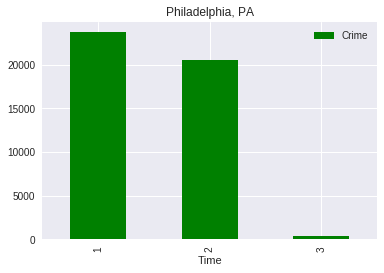

In [74]:
df = phili.dfc.between_time(start_time = '01:00', end_time = '03:00')
df.groupby(df.index.hour).count().plot(kind = 'bar', title = 'Philadelphia, PA', color = 'g')

### Results and Conclusions <a class="anchor" id="results"></a>

[Back to Table of Contents](#toc)